In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/imagenette2-320.tgz' '/content/imagenette.tgz'

In [0]:
!tar -xf /content/imagenette.tgz

## Importing Libraries

In [0]:
import tensorflow as tf
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [0]:
batch_size = 8
epochs = 50
num_classes=10

In [0]:
image_h, image_w = 256, 256
classes = sorted(['n03417042', 'n03028079', 'n03888257', 'n02102040', 'n01440764', 'n03445777', 'n03000684', 'n02979186', 'n03394916', 'n03425413'])
label_map = {v:i for i, v in enumerate(classes)}

def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img[:,:,::-1] - tf.constant([103.939, 116.779, 123.68])
  return img

train_images = glob('/content/imagenette/train/*/*')
np.random.shuffle(train_images)
train_labels = [label_map[x.split('/')[4]] for x in train_images]

val_images = glob('/content/imagenette/val/*/*')
np.random.shuffle(val_images)
val_labels = [label_map[x.split('/')[4]] for x in val_images]

def load_data(image_path, label):
  image = read_img(image_path)
  return image, label


## Creating data generator


In [0]:
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

## Visualizing Input Images

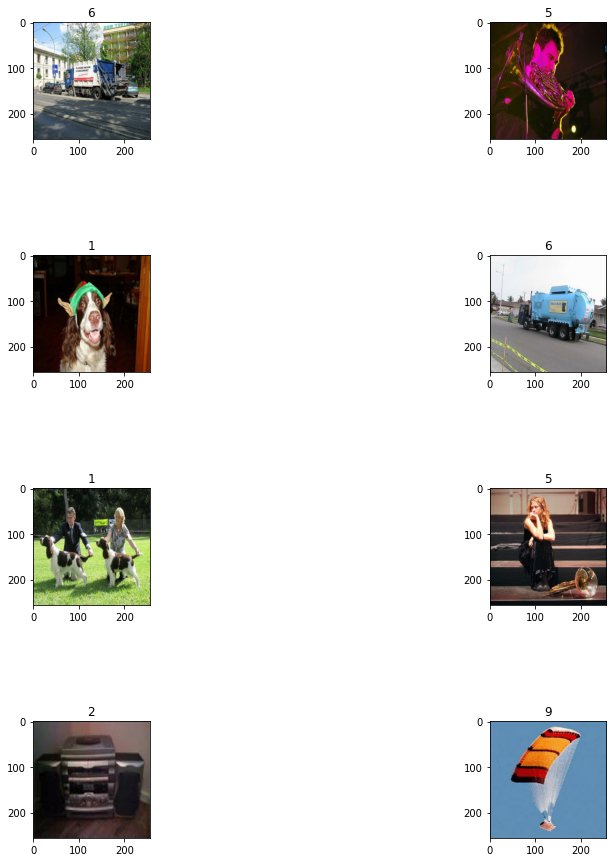

In [14]:
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      img  = (val[0][i] + tf.constant([103.939, 116.779, 123.68]))[:,:,::-1]
      plt.subplot(4,2,i+1)
      plt.imshow(tf.cast(img,tf.uint8))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(hspace=1)
  plt.show()

train_dataset = data_generator(train_images,train_labels)
val_dataset = data_generator(val_images,val_labels)
show_img(train_dataset)

## Squeeze Excitation Block
![picture](https://i.imgur.com/ufAxbPN.png)


In [0]:
def squeeze_excitation_layer(input_layer, out_dim, ratio, conv):
  squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
  
  excitation = tf.keras.layers.Dense(units=out_dim / ratio, activation='relu')(squeeze)
  excitation = tf.keras.layers.Dense(out_dim,activation='sigmoid')(excitation)
  excitation = tf.reshape(excitation, [-1,1,1,out_dim])
  
  scale = tf.keras.layers.multiply([input_layer, excitation])
  
  if conv:
    shortcut = tf.keras.layers.Conv2D(out_dim,kernel_size=1,strides=1,
                                      padding='same',kernel_initializer='he_normal')(input_layer)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
  else:
    shortcut = input_layer
  out = tf.keras.layers.add([shortcut, scale])
  return out

![Picture](https://i.imgur.com/0630d2v.png)

In [16]:
def conv_block(input_layer,filters):
  layer = tf.keras.layers.Conv2D(filters,kernel_size=1,strides=1,
                                 padding='same',kernel_initializer='he_normal',
                                 use_bias=False)(input_layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(filters,kernel_size=3,strides=1,
                                 padding='same',kernel_initializer='he_normal',
                                 use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(filters*4,kernel_size=1,strides=1,
                                 padding='same',kernel_initializer='he_normal',
                                 use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  return layer

def SE_ResNet50(input_w,input_h,include_top):
  model_input = tf.keras.layers.Input(shape=(input_w,input_h,3))
  identity_blocks =[3, 4, 6, 3]
  #Block 1
  layer = tf.keras.layers.Conv2D(64,kernel_size=3,strides=1,
                                 padding='same',kernel_initializer='he_normal',
                                 use_bias=False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  block_1 =  tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(layer)
  
  #Block 2
  block_2 = conv_block(block_1,64)
  block_2 = squeeze_excitation_layer(block_2, out_dim=256, ratio=32.0, conv=True)
  for _ in range(identity_blocks[0]-1):
    block_2 = conv_block(block_1,64)
    block_2 = squeeze_excitation_layer(block_2, out_dim=256, ratio=32.0, conv=False)

  #Block 3
  block_3 = conv_block(block_2,128)
  block_3 = squeeze_excitation_layer(block_3, out_dim=512, ratio=32.0, conv=True)
  for _ in range(identity_blocks[1]-1):
    block_3 = conv_block(block_2, 128)
    block_3 = squeeze_excitation_layer(block_3, out_dim=512, ratio=32.0, conv=False)


  #Block 4
  block_4 = conv_block(block_3,256)
  block_4 = squeeze_excitation_layer(block_4, out_dim=1024, ratio=32.0, conv=True)
  for _ in range(identity_blocks[2]-1):
    block_4 = conv_block(block_3, 256)
    block_4 = squeeze_excitation_layer(block_4, out_dim=1024, ratio=32.0, conv=False)


  #Block 5
  block_5 = conv_block(block_4,512)
  block_5 = squeeze_excitation_layer(block_5, out_dim=2048, ratio=32.0, conv=True)
  for _ in range(identity_blocks[2]-1):
    block_5 = conv_block(block_4, 512)
    block_5 = squeeze_excitation_layer(block_5, out_dim=2048, ratio=32.0, conv=False)

  if include_top:
    pooling = tf.keras.layers.GlobalAveragePooling2D()(block_5)
    model_output = tf.keras.layers.Dense(10,
                                        activation='softmax')(pooling)
  
    model = tf.keras.models.Model(model_input,model_output)
  else:
    model = tf.keras.models.Model(model_input,block_5)
  model.summary()
  return model

model = SE_ResNet50(image_w,image_h,include_top=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
starter_learning_rate = 1e-2
end_learning_rate = 1e-5
decay_steps = 80000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.8)

model.compile(loss=tf.losses.SparseCategoricalCrossentropy
              (from_logits=True), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn), 
              metrics=[tf.metrics.SparseCategoricalAccuracy()])


callbacks = [
    tf.keras.callbacks.ModelCheckpoint('SE_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(train_dataset,
          epochs=epochs,steps_per_epoch=len(train_images)//batch_size,
          callbacks=callbacks)

Epoch 1/50
1183/1183 [==============================] - 1440s 1s/step - loss: 2.1125 - sparse_categorical_accuracy: 0.3590
Epoch 2/50
1183/1183 [==============================] - 1440s 1s/step - loss: 2.0672 - sparse_categorical_accuracy: 0.4007
Epoch 3/50
1183/1183 [==============================] - 1439s 1s/step - loss: 2.0402 - sparse_categorical_accuracy: 0.4286
Epoch 4/50
1183/1183 [==============================] - 1439s 1s/step - loss: 2.0162 - sparse_categorical_accuracy: 0.4508
Epoch 5/50
1183/1183 [==============================] - 1439s 1s/step - loss: 1.9979 - sparse_categorical_accuracy: 0.4695
Epoch 6/50
1183/1183 [==============================] - 1440s 1s/step - loss: 1.9841 - sparse_categorical_accuracy: 0.4840
Epoch 7/50
1183/1183 [==============================] - 1437s 1s/step - loss: 1.9664 - sparse_categorical_accuracy: 0.5012
Epoch 8/50
1183/1183 [==============================] - 1434s 1s/step - loss: 1.9562 - sparse_categorical_accuracy: 0.5119
Epoch 9/50
1183/

KeyboardInterrupt: ignored

## Inference

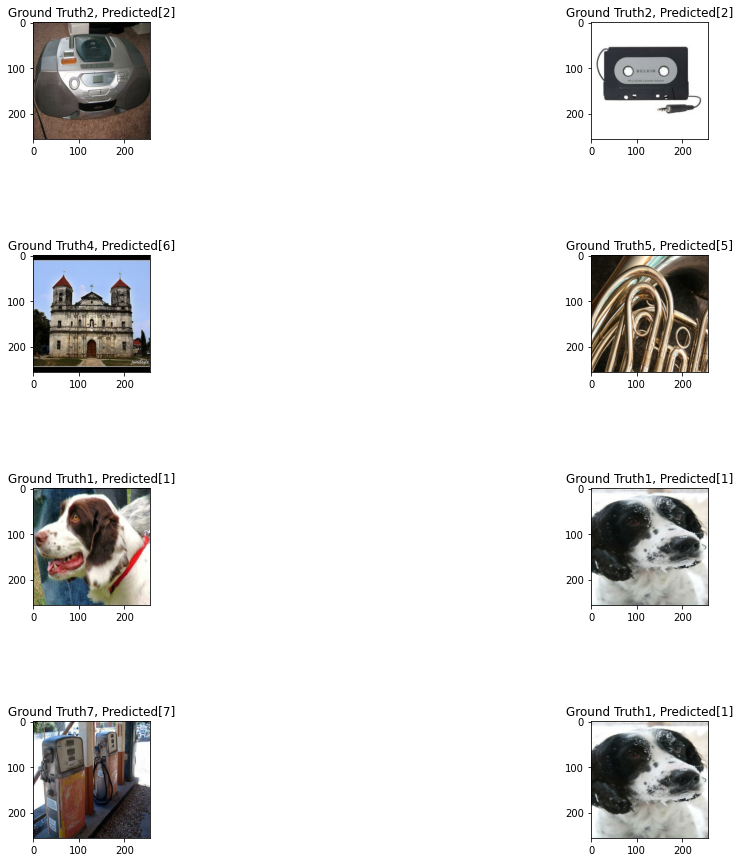

In [23]:
plt.figure(figsize=(15,15))
for i in range(8):
  for val in val_dataset.take(1):
    plt.subplot(4,2,i+1)
    img  = (val[0][i] + tf.constant([103.939, 116.779, 123.68]))[:,:,::-1]
    plt.imshow(tf.cast(img,tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()